## q_2_b

In [43]:
import numpy as np
import pandas as pd
import os
import re
from tqdm import tqdm
import datetime

In [44]:
b1_data = pd.read_excel(r'E:\教材\华科\研二上\数模\MCM\竞赛发布数据\表1-患者列表及临床信息.xlsx')
train_ID = b1_data['Unnamed: 0'].tolist()[:100]
new_b2_data = pd.read_csv(r'E:\教材\华科\研二上\数模\MCM\竞赛发布数据\表2-long.csv', dtype = str)
new_b2_data = new_b2_data[new_b2_data['ID'].isin(train_ID)]
new_b2_data['ED_volume'] = [float(x) for x in new_b2_data['ED_volume']]
new_b2_data = new_b2_data[['ID', 'follow_up_count', '流水号', 'ED_volume']].copy()
new_b2_data['ED_volume'] = [float(x) for x in new_b2_data['ED_volume']]

## 根据ID，连接其发病时间
b1_data = pd.read_excel(r'E:\教材\华科\研二上\数模\MCM\竞赛发布数据\表1-患者列表及临床信息.xlsx', dtype = str)
b1_data = b1_data[['Unnamed: 0', '发病到首次影像检查时间间隔']]
b1_data.columns = ['ID', '发病到首次影像检查时间间隔']
b1_data['发病到首次影像检查时间间隔'] = [float(x) for x in b1_data['发病到首次影像检查时间间隔']]
new_b2_data = pd.merge(new_b2_data, b1_data, left_on = "ID", right_on = "ID", how = "left")

## 根据流水号，连接其流水号发生时间
fb1_data = pd.read_csv(r'E:\教材\华科\研二上\数模\MCM\竞赛发布数据\附表1-long.csv', dtype = str)
tmp1, tmp2 = fb1_data[['sub_code', '入院首次检查流水号', '入院首次检查时间点']].copy(), fb1_data[['sub_code', '流水号', '时间点']].copy()
tmp1.columns = ['ID', '流水号', '时间点']
tmp2.columns = ['ID', '流水号', '时间点']
fb1_data = pd.concat([tmp1, tmp2], axis = 0)
fb1_data = fb1_data.drop_duplicates()
new_b2_data = pd.merge(new_b2_data, fb1_data, left_on = ["ID", "流水号"], right_on = ["ID", "流水号"], how = "left")
new_b2_data['时间点'] = [datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ) for x in new_b2_data['时间点']]

new_b2_data['first_examination'] = 0
for i_row in tqdm(range(len(new_b2_data))):
    tmp_id = new_b2_data.loc[i_row, 'ID']
    tmp_df = new_b2_data[new_b2_data['ID'] == tmp_id]
    tmp_df = tmp_df[tmp_df['follow_up_count'] == '0']['时间点'].values[0]
    
    new_b2_data.loc[i_row, 'first_examination'] = pd.Timestamp(tmp_df)        ## 这里的tmp_df为时间的值
    
    
new_b2_data['time_from_disease'] = new_b2_data['时间点'] - new_b2_data['first_examination']
new_b2_data['time_from_disease'] = [x.days * 24 + x.seconds / 3600 for x in new_b2_data['time_from_disease']]
new_b2_data['time_from_disease'] = new_b2_data['time_from_disease'] + new_b2_data['发病到首次影像检查时间间隔']

## 异常值处理
def three_sigma(array):
    mu = np.mean(array)
    sigma = np.std(array)
    list_res = []
    for i in array:
        if i > mu + 3 * sigma:
            list_res.append(mu + 3 * sigma)
        elif i < mu - 3 * sigma:
            list_res.append(mu - 3 * sigma)
        else:
            list_res.append(i)
    return list_res
new_b2_data['ED_volume'] = three_sigma(new_b2_data['ED_volume'])
new_b2_data

100%|██████████| 450/450 [00:00<00:00, 758.29it/s]
e:\Anaconda\lib\site-packages\pandas\core\arrays\datetimelike.py:1190: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


,ID,follow_up_count,流水号,ED_volume,发病到首次影像检查时间间隔,时间点,first_examination,time_from_disease
0,sub001,0,20161212002136,48919.000000,2.5,2016-12-12 23:32:54,2016-12-12 23:32:54,2.500000
1,sub001,1,20161213000009,57898.000000,2.5,2016-12-13 05:19:00,2016-12-12 23:32:54,8.268333
2,sub001,2,20161218000100,81747.000000,2.5,2016-12-18 09:09:24,2016-12-12 23:32:54,132.108333
3,sub001,3,20161223001020,104758.882133,2.5,2016-12-23 16:47:09,2016-12-12 23:32:54,259.737500
4,sub001,4,20161230000574,104758.882133,2.5,2016-12-30 14:35:12,2016-12-12 23:32:54,425.538333
...,...,...,...,...,...,...,...,...
445,sub099,1,20180621000781,19517.000000,3.0,2018-06-21 09:43:31,2018-06-20 19:03:09,17.672778
446,sub099,2,20180622000871,30933.000000,3.0,2018-06-22 10:34:55,2018-06-20 19:03:09,42.529444
447,sub100,0,20180314000010,7367.000000,0.5,2018-03-14 04:46:39,2018-03-14 04:46:39,0.500000
448,sub100,1,20180315001448,6033.000000,0.5,2018-03-15 15:00:31,2018-03-14 04:46:39,34.731111


In [45]:
b2_ts_feature = pd.DataFrame()
for i_ID in tqdm(train_ID):
    tmp_df = new_b2_data[new_b2_data['ID'] == i_ID]
    i_x = tmp_df['time_from_disease'].to_numpy()
    i_y = tmp_df['ED_volume'].to_numpy()
    
    tmp_model = np.polyfit(i_x, i_y, 2)
    tmp_feature = pd.DataFrame([[i_ID] + list(tmp_model)], columns = ['ID', 'poly_a', 'poly_b', 'poly_c'])
    
    if b2_ts_feature.empty:
        b2_ts_feature = tmp_feature
    else:
        b2_ts_feature = pd.concat([b2_ts_feature, tmp_feature], axis = 0)

b2_ts_feature

100%|██████████| 100/100 [00:00<00:00, 630.62it/s]


,ID,poly_a,poly_b,poly_c
0,sub001,-0.425057,308.013310,51219.236021
0,sub002,-0.070028,57.355895,23487.210898
0,sub003,-23.163848,1419.580749,29874.493895
0,sub004,0.538920,-197.683182,22288.734233
0,sub005,10.585728,-1460.857644,54431.645022
...,...,...,...,...
0,sub096,-0.060241,21.366640,6837.972720
0,sub097,0.015216,-55.569264,10393.570847
0,sub098,-0.049512,31.725587,31492.197003
0,sub099,-5.388191,783.654209,7350.531087


In [46]:
## 将b2_ts_feature与患者发病与首诊时间间隔左连接
tmp_data = new_b2_data.groupby('ID').mean()
tmp_data['ID'] = tmp_data.index
tmp_data = tmp_data[['ID', '发病到首次影像检查时间间隔']]
tmp_data.index = pd.RangeIndex(0, len(tmp_data))
b2_ts_feature = pd.merge(b2_ts_feature, tmp_data, left_on = 'ID', right_on = 'ID', how = 'left')
b2_ts_feature

,ID,poly_a,poly_b,poly_c,发病到首次影像检查时间间隔
0,sub001,-0.425057,308.013310,51219.236021,2.5
1,sub002,-0.070028,57.355895,23487.210898,3.0
2,sub003,-23.163848,1419.580749,29874.493895,2.0
3,sub004,0.538920,-197.683182,22288.734233,1.0
4,sub005,10.585728,-1460.857644,54431.645022,5.0
...,...,...,...,...,...
95,sub096,-0.060241,21.366640,6837.972720,1.0
96,sub097,0.015216,-55.569264,10393.570847,3.0
97,sub098,-0.049512,31.725587,31492.197003,2.5
98,sub099,-5.388191,783.654209,7350.531087,3.0


In [47]:
## 将b2_ts_feature与患者发病与最后随诊时间间隔左连接
tmp_data = new_b2_data.groupby('ID').max('time_from_disease')
tmp_data['ID'] = tmp_data.index
tmp_data.index = pd.RangeIndex(0, len(tmp_data))
tmp_data = tmp_data[['ID', 'time_from_disease']]
tmp_data.columns = ['ID', 'max_follow_up_time']
b2_ts_feature = pd.merge(b2_ts_feature, tmp_data, left_on = 'ID', right_on = 'ID', how = 'left')
b2_ts_feature

,ID,poly_a,poly_b,poly_c,发病到首次影像检查时间间隔,max_follow_up_time
0,sub001,-0.425057,308.013310,51219.236021,2.5,425.538333
1,sub002,-0.070028,57.355895,23487.210898,3.0,1119.191944
2,sub003,-23.163848,1419.580749,29874.493895,2.0,39.595833
3,sub004,0.538920,-197.683182,22288.734233,1.0,227.501111
4,sub005,10.585728,-1460.857644,54431.645022,5.0,97.943056
...,...,...,...,...,...,...
95,sub096,-0.060241,21.366640,6837.972720,1.0,595.642778
96,sub097,0.015216,-55.569264,10393.570847,3.0,171.400278
97,sub098,-0.049512,31.725587,31492.197003,2.5,903.368333
98,sub099,-5.388191,783.654209,7350.531087,3.0,42.529444


In [48]:
b2_ts_feature['feature_B_1'] = b2_ts_feature['poly_b'] / (- 2 * b2_ts_feature['poly_a']) - b2_ts_feature['发病到首次影像检查时间间隔']
b2_ts_feature['feature_B_2'] = b2_ts_feature['max_follow_up_time'] - b2_ts_feature['poly_b'] / (- 2 * b2_ts_feature['poly_a'])
b2_ts_feature

,ID,poly_a,poly_b,poly_c,发病到首次影像检查时间间隔,max_follow_up_time,feature_B_1,feature_B_2
0,sub001,-0.425057,308.013310,51219.236021,2.5,425.538333,359.820222,63.218112
1,sub002,-0.070028,57.355895,23487.210898,3.0,1119.191944,406.521694,709.670250
2,sub003,-23.163848,1419.580749,29874.493895,2.0,39.595833,28.642161,8.953672
3,sub004,0.538920,-197.683182,22288.734233,1.0,227.501111,182.406740,44.094371
4,sub005,10.585728,-1460.857644,54431.645022,5.0,97.943056,64.001285,28.941771
...,...,...,...,...,...,...,...,...
95,sub096,-0.060241,21.366640,6837.972720,1.0,595.642778,176.343671,418.299106
96,sub097,0.015216,-55.569264,10393.570847,3.0,171.400278,1823.014579,-1654.614301
97,sub098,-0.049512,31.725587,31492.197003,2.5,903.368333,317.881882,582.986451
98,sub099,-5.388191,783.654209,7350.531087,3.0,42.529444,69.719608,-30.190164


In [49]:
b2_ts_feature = b2_ts_feature[['ID', 'poly_a', 'feature_B_1', 'feature_B_2', 'poly_c']]
b2_ts_feature

,ID,poly_a,feature_B_1,feature_B_2,poly_c
0,sub001,-0.425057,359.820222,63.218112,51219.236021
1,sub002,-0.070028,406.521694,709.670250,23487.210898
2,sub003,-23.163848,28.642161,8.953672,29874.493895
3,sub004,0.538920,182.406740,44.094371,22288.734233
4,sub005,10.585728,64.001285,28.941771,54431.645022
...,...,...,...,...,...
95,sub096,-0.060241,176.343671,418.299106,6837.972720
96,sub097,0.015216,1823.014579,-1654.614301,10393.570847
97,sub098,-0.049512,317.881882,582.986451,31492.197003
98,sub099,-5.388191,69.719608,-30.190164,7350.531087


## 聚类

In [50]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt


sns.set_style('whitegrid')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [51]:
cluster_data = b2_ts_feature.copy()
for cloumn in ['poly_a', 'feature_B_1', 'feature_B_2', 'poly_c']:
    cluster_data[cloumn] = three_sigma(cluster_data[cloumn])

scaler = MinMaxScaler()
cluster_data[['poly_a', 'feature_B_1', 'feature_B_2', 'poly_c']] = scaler.fit_transform(cluster_data[['poly_a', 'feature_B_1', 'feature_B_2', 'poly_c']])
cluster_data.index = cluster_data['ID']
cluster_data = cluster_data.drop(['ID'], axis = 1)
cluster_data_array = cluster_data.to_numpy()
cluster_data_array

array([[0.8780578 , 0.48166409, 0.48253389, 0.74991698],
       [0.88103902, 0.48730887, 0.5688373 , 0.39377577],
       [0.68711697, 0.44163477, 0.47528942, 0.47580276],
       [0.88615245, 0.46022021, 0.47998081, 0.37838465],
       [0.9705169 , 0.44590861, 0.47795789, 0.79117149],
       [0.88047468, 0.32438503, 0.63470613, 1.        ],
       [0.87926658, 0.47536414, 0.48528309, 0.34654113],
       [0.85284906, 0.44997795, 0.48395418, 0.33827958],
       [1.        , 0.44018388, 0.48061599, 0.33768617],
       [0.88188302, 0.53919453, 0.48941458, 0.36044226],
       [0.883592  , 0.46215821, 0.49186802, 0.15858169],
       [0.8806761 , 0.51060445, 0.56361533, 0.24099781],
       [0.8812661 , 0.46739306, 0.54334429, 0.21919495],
       [0.87228671, 0.45685688, 0.48525794, 0.24556082],
       [0.87781615, 0.49012677, 0.50156306, 0.        ],
       [0.87625428, 0.49491273, 0.42829192, 0.45627164],
       [0.87808233, 0.47275447, 0.49913923, 0.27975884],
       [0.86490153, 0.45733145,

In [52]:
silhouette = []
for i_cluster in range(3, 9):
    cluster = KMeans(n_clusters = i_cluster, random_state=10).fit(cluster_data_array)
    y_pred = cluster.labels_
    silhouette_avg = silhouette_score(cluster_data_array, y_pred)
    silhouette.append(silhouette_avg)



e:\Anaconda\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
e:\Anaconda\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
e:\Anaconda\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.floa

e:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
e:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
e:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


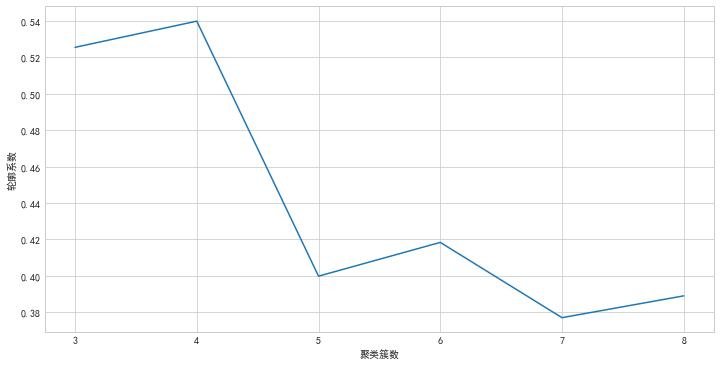

In [53]:
plt.figure(figsize = (12, 6))
sns.lineplot(x = range(3, 9), y = silhouette)
plt.xlabel('聚类簇数')
plt.ylabel('轮廓系数')
plt.savefig(os.path.dirname(os.path.dirname(__vsc_ipynb_file__)) + ".\\plots\\轮廓系数与簇数.png", bbox_inches = 'tight', dpi = 600)

In [54]:
cluster = KMeans(n_clusters = 4, random_state=10).fit(cluster_data_array)
y_pred = cluster.labels_
y_pred

e:\Anaconda\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
e:\Anaconda\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
e:\Anaconda\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.floa

array([1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0])

In [55]:
cluster_df = pd.DataFrame([np.array(train_ID), np.array(y_pred)]).T
cluster_df.columns = ['ID', 'cluster']
cluster_df[cluster_df['ID'] == 'sub081']        ## 第80行是sub081
cluster_df.loc[80, 'cluster'] = 3

e:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
e:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


e:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
e:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
e:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
e:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy

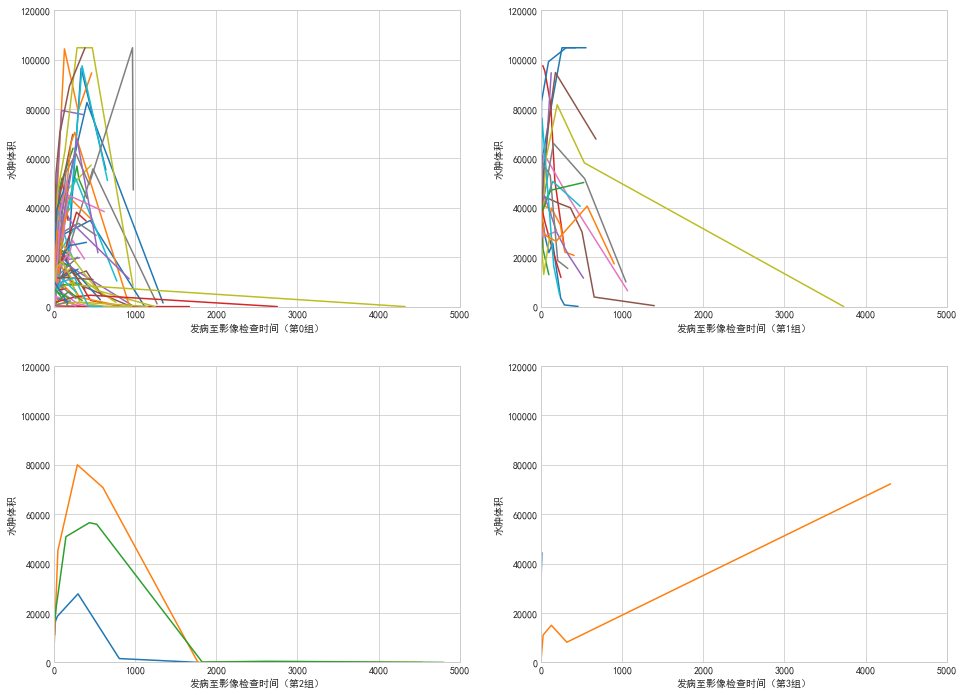

In [56]:
plt.figure(figsize = (16, 12))
for i_cluster in cluster_df['cluster'].unique():
    i_IDs = cluster_df[cluster_df['cluster'] == i_cluster]['ID'].tolist()
    tmp_df = new_b2_data[new_b2_data['ID'].isin(i_IDs)]
    plt.subplot(2, len(cluster_df['cluster'].unique()) // 2, i_cluster + 1)
    for i_ID in tmp_df['ID'].unique():
        tmp_tmp_df = tmp_df[tmp_df['ID'] == i_ID]
        sns.lineplot(x = tmp_tmp_df['time_from_disease'], y = tmp_tmp_df['ED_volume'])
        plt.xlim(0, 5000)
        plt.ylim(0, 120000)
        plt.xlabel('发病至影像检查时间（第{}组）'.format(i_cluster))
        plt.ylabel('水肿体积')
        
plt.savefig(os.path.dirname(os.path.dirname(__vsc_ipynb_file__)) + ".\\plots\\不同亚种水肿体积随时间进展曲线.png", bbox_inches = 'tight', dpi = 600)

## 分组模型拟合

In [57]:
import sklearn.pipeline as pl
import sklearn.preprocessing as sp
import sklearn.linear_model as lm
import statsmodels.api as sm
import scipy.optimize as optimize

e:\Anaconda\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
e:\Anaconda\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
e:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
e:\Anaconda\lib\site-packages\matplotlib\axes\_base.

e:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
e:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
e:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
e:\Anaconda\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

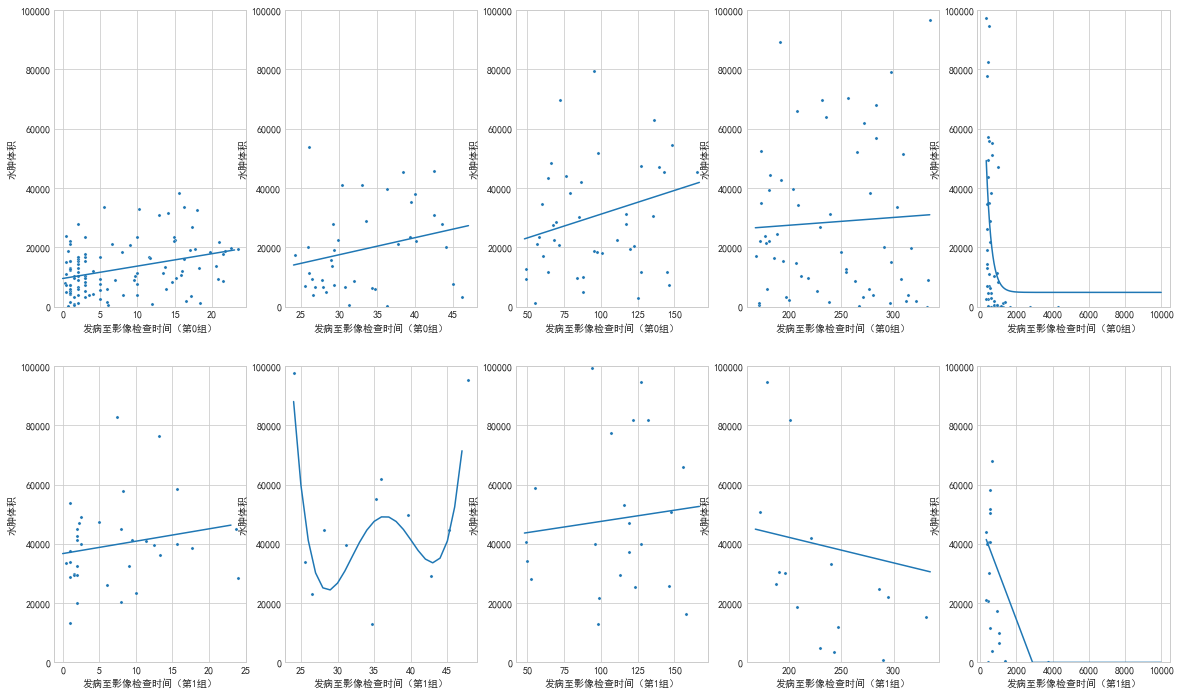

In [58]:
## 前两组拟合
plt.figure(figsize = (20, 12))
model_param_list = []
# deg_list = [2, 2, 2, 1]
time_var = [0, 24, 48, 7 * 24, 14 * 24, 9999]
k = 1

model_param_list = []

cluster_error_df = pd.DataFrame()
for i_cluster in np.sort(cluster_df['cluster'].unique())[:2]:
    i_IDs = cluster_df[cluster_df['cluster'] == i_cluster]['ID'].tolist()
    tmp_data = new_b2_data[new_b2_data['ID'].isin(i_IDs)]
    
    for i in range(len(time_var) - 1):
        tmp_df = tmp_data[(tmp_data['time_from_disease'] >= time_var[i]) & (tmp_data['time_from_disease'] < time_var[i + 1])]
        x, y = tmp_df['time_from_disease'].to_numpy().reshape(-1, 1), tmp_df['ED_volume'].to_numpy()
        
        if i < 4:
            bic_list = []
            for poly in range(1, 5):
                x, y = tmp_df['time_from_disease'].to_numpy().reshape(-1, 1), tmp_df['ED_volume'].to_numpy()
                model = sp.PolynomialFeatures(degree = poly)
                x = model.fit_transform(x)
                poly_fit = sm.OLS(y, x).fit()
                bic_list.append(poly_fit.bic)
                # print(i, poly, poly_fit.bic)
            min_poly = list(range(1, 5))[bic_list.index(min(bic_list))]
            
            x, y = tmp_df['time_from_disease'].to_numpy().reshape(-1, 1), tmp_df['ED_volume'].to_numpy()
            model = sp.PolynomialFeatures(degree = min_poly)
            x = model.fit_transform(x)
            poly_fit = sm.OLS(y, x).fit()
            def fit_fun(x, i, params):
                if i < 4:
                    res = 0
                    for i_pointer, i_para in enumerate(params):
                        res += i_para * (x ** i_pointer)
                else:
                    res = target_func(x, params[0], params[1], params[2])
                return float(res)
            # print(poly_fit.params)
            # x_plot = np.arange(time_var[i], time_var[i + 1]).reshape(-1, 1)
            # x_plot = model.fit_transform(x_plot)
            # y_plot = poly_fit.predict(x_plot)
            
            y_pred = [fit_fun(a, i, poly_fit.params) for a in tmp_df['time_from_disease'].to_numpy()]
            
            model_param_list.append(poly_fit.params)
            x_plot = np.arange(time_var[i], time_var[i + 1])
            y_plot = [fit_fun(a, i, poly_fit.params) for a in x_plot]
        else:
            def target_func(x, a0, a1, a2):
                return a0 * np.exp(-x / a1) + a2

            x = x.flatten()
            a0 = max(y) - min(y)
            a1 = x[round(len(x) / 2)]
            a2 = min(y)
            p0 = [a0, a1, a2]
            
            para, cov = optimize.curve_fit(target_func, x, y, p0=p0)
            
            # print(para)
            model_param_list.append(para)
            x_plot = np.arange(time_var[i], time_var[i + 1])
            y_plot = np.clip([fit_fun(a, i, para) for a in x_plot], 0, float('inf'))
            y_pred = np.clip([fit_fun(a, i, para) for a in tmp_df['time_from_disease'].to_numpy()], 0, float('inf'))
        
        tmp_df['pred_y'] = y_pred
        tmp_df['cluster'] = i_cluster
        
        if cluster_error_df.empty:
            cluster_error_df = tmp_df
        else:
            cluster_error_df = pd.concat([cluster_error_df, tmp_df], axis = 0)
    
    # i_x, i_y = tmp_df['time_from_disease'], tmp_df['ED_volume']
    # poly_fit = np.polyfit(i_x, i_y, deg_list[i_cluster])
    
    # i_x_plot = np.arange(0, max(i_x))
    # i_y_plot = np.clip(np.polyval(poly_fit, i_x_plot), 0, np.inf)
    
    # tmp_df['ED_volume_pred'] = np.clip(np.polyval(poly_fit, tmp_df['time_from_disease']), 0, np.inf)
    # tmp_df['cluster'] = i_cluster
    
    # if cluster_error_df.empty:
    #     cluster_error_df = tmp_df[['ID', 'cluster', 'time_from_disease', 'ED_volume', 'ED_volume_pred']]
    # else:
    #     cluster_error_df = pd.concat([cluster_error_df, tmp_df[['ID', 'cluster', 'time_from_disease', 'ED_volume', 'ED_volume_pred']]], axis = 0)
    
        plt.subplot(2, 5, k)
        sns.scatterplot(x = tmp_df['time_from_disease'], y = tmp_df['ED_volume'], s = 10)
        sns.lineplot(x = x_plot, y = y_plot)
        plt.xlabel('发病至影像检查时间（第{}组）'.format(i_cluster))
        plt.ylabel('水肿体积')
        plt.ylim(0, 100000)
        # plt.xlim(0, 5000)
        k += 1
plt.savefig(os.path.dirname(os.path.dirname(__vsc_ipynb_file__)) + ".\\plots\\01组拟合.png", bbox_inches = 'tight', dpi = 600)

In [59]:
model_param_list

[array([9476.08805514,  418.583487  ]),
 array([168.78516641, 577.35086911]),
 array([15162.80502033,   160.04743202]),
 array([22173.52460347,    26.28076057]),
 array([144526.26909197,    285.07839812,   4795.29519235]),
 array([36698.09832169,   417.52691413]),
 array([ 1.18223880e+07, -1.36430704e+06,  5.83440059e+04, -1.09315694e+03,
         7.57925472e+00]),
 array([40004.09275249,    75.51107569]),
 array([59426.65022207,   -86.20253033]),
 array([-1.43120986e+08, -8.81258153e+06,  1.43167890e+08])]

In [60]:
cluster_error_df.sort_values('ID')

,ID,follow_up_count,流水号,ED_volume,发病到首次影像检查时间间隔,时间点,first_examination,time_from_disease,pred_y,cluster
0,sub001,0,20161212002136,48919.000000,2.5,2016-12-12 23:32:54,2016-12-12 23:32:54,2.500000,37741.915607,1
1,sub001,1,20161213000009,57898.000000,2.5,2016-12-13 05:19:00,2016-12-12 23:32:54,8.268333,40150.350023,1
2,sub001,2,20161218000100,81747.000000,2.5,2016-12-18 09:09:24,2016-12-12 23:32:54,132.108333,49979.735110,1
3,sub001,3,20161223001020,104758.882133,2.5,2016-12-23 16:47:09,2016-12-12 23:32:54,259.737500,37036.620500,1
4,sub001,4,20161230000574,104758.882133,2.5,2016-12-30 14:35:12,2016-12-12 23:32:54,425.538333,39993.421325,1
...,...,...,...,...,...,...,...,...,...,...
445,sub099,1,20180621000781,19517.000000,3.0,2018-06-21 09:43:31,2018-06-20 19:03:09,17.672778,16873.621002,0
446,sub099,2,20180622000871,30933.000000,3.0,2018-06-22 10:34:55,2018-06-20 19:03:09,42.529444,24723.196879,0
447,sub100,0,20180314000010,7367.000000,0.5,2018-03-14 04:46:39,2018-03-14 04:46:39,0.500000,9685.379799,0
448,sub100,1,20180315001448,6033.000000,0.5,2018-03-15 15:00:31,2018-03-14 04:46:39,34.731111,20220.822352,0


e:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
e:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
e:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
e:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

e:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
e:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
e:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
e:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

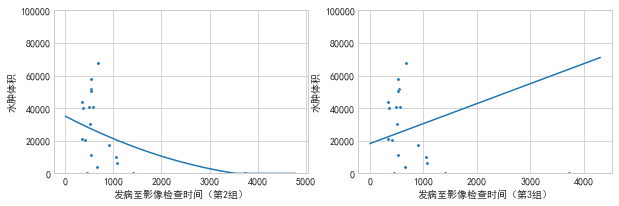

In [61]:
## 后两组拟合
plt.figure(figsize = (10, 3))
cluster_error_df_2 = pd.DataFrame()
model_param_list_2 = []
deg_list = [2, 1]
for i_cluster in np.sort(cluster_df['cluster'].unique())[2:]:
    i_IDs = cluster_df[cluster_df['cluster'] == i_cluster]['ID'].tolist()
    tmp_data = new_b2_data[new_b2_data['ID'].isin(i_IDs)]
    
    x, y = tmp_data['time_from_disease'].to_numpy(), tmp_data['ED_volume'].to_numpy()
    
    poly_model = np.polyfit(x, y, deg_list[i_cluster - 2])
    
    x_plot = np.arange(0, max(x))
    y_plot = np.clip(np.polyval(poly_model, x_plot), 0, float('inf'))
    
    model_param_list_2.append(poly_model)
    
    plt.subplot(1, 2, i_cluster - 1)
    sns.scatterplot(x = tmp_df['time_from_disease'], y = tmp_df['ED_volume'], s = 10)
    sns.lineplot(x = x_plot, y = y_plot)
    plt.xlabel('发病至影像检查时间（第{}组）'.format(i_cluster))
    plt.ylabel('水肿体积')
    plt.ylim(0, 100000)
    # plt.xlim(0, 5000)
    y_pred = np.clip(np.polyval(poly_model, x), 0, float('inf'))
    tmp_data['pred_y'] = y_pred
    tmp_data['cluster'] = i_cluster
    if cluster_error_df_2.empty:
        cluster_error_df_2 = tmp_data
    else:
        cluster_error_df_2 = pd.concat([cluster_error_df_2, tmp_data], axis = 0)
    
plt.savefig(os.path.dirname(os.path.dirname(__vsc_ipynb_file__)) + ".\\plots\\23组拟合.png", bbox_inches = 'tight', dpi = 600)    

In [62]:
cluster_error_df_2

,ID,follow_up_count,流水号,ED_volume,发病到首次影像检查时间间隔,时间点,first_examination,time_from_disease,pred_y,cluster
77,sub019,0,20160117000135,11107.0,9.0,2016-01-17 10:22:25,2016-01-17 10:22:25,9.000000,34917.189833,2
78,sub019,1,20160117000328,16594.0,9.0,2016-01-17 19:41:40,2016-01-17 10:22:25,18.320833,34775.045071,2
79,sub019,2,20160118001751,18649.0,9.0,2016-01-18 20:00:35,2016-01-17 10:22:25,42.636111,34405.478450,2
80,sub019,3,20160129000231,27745.0,9.0,2016-01-29 10:16:29,2016-01-17 10:22:25,296.901111,30648.892818,2
81,sub019,4,20160219000980,1549.0,9.0,2016-02-19 15:15:16,2016-01-17 10:22:25,805.880833,23721.251010,2
82,sub019,5,20160331000374,0.0,9.0,2016-03-31 09:44:59,2016-01-17 10:22:25,1784.376111,12621.780857,2
226,sub052,0,20170608001310,7036.0,4.0,2017-06-08 13:45:09,2017-06-08 13:45:09,4.000000,34993.550084,2
227,sub052,1,20170610000326,45266.0,4.0,2017-06-10 10:39:23,2017-06-08 13:45:09,48.903889,34310.507026,2
228,sub052,2,20170620000788,79961.0,4.0,2017-06-20 10:52:34,2017-06-08 13:45:09,289.123611,30760.877616,2
229,sub052,3,20170703001407,70743.0,4.0,2017-07-03 14:05:27,2017-06-08 13:45:09,604.338333,26369.962521,2


In [63]:
model_param_list_2

[array([ 1.52435067e-03, -1.52918669e+01,  3.50546932e+04]),
 array([1.22647141e+01, 1.82603217e+04])]

In [64]:
all_cluster_error = pd.concat([cluster_error_df, cluster_error_df_2], axis = 0).sort_values('ID')
all_cluster_error['pred_error'] = all_cluster_error['ED_volume'] - all_cluster_error['pred_y']
all_cluster_error

,ID,follow_up_count,流水号,ED_volume,发病到首次影像检查时间间隔,时间点,first_examination,time_from_disease,pred_y,cluster,pred_error
0,sub001,0,20161212002136,48919.000000,2.5,2016-12-12 23:32:54,2016-12-12 23:32:54,2.500000,37741.915607,1,11177.084393
1,sub001,1,20161213000009,57898.000000,2.5,2016-12-13 05:19:00,2016-12-12 23:32:54,8.268333,40150.350023,1,17747.649977
2,sub001,2,20161218000100,81747.000000,2.5,2016-12-18 09:09:24,2016-12-12 23:32:54,132.108333,49979.735110,1,31767.264890
3,sub001,3,20161223001020,104758.882133,2.5,2016-12-23 16:47:09,2016-12-12 23:32:54,259.737500,37036.620500,1,67722.261633
4,sub001,4,20161230000574,104758.882133,2.5,2016-12-30 14:35:12,2016-12-12 23:32:54,425.538333,39993.421325,1,64765.460808
...,...,...,...,...,...,...,...,...,...,...,...
445,sub099,1,20180621000781,19517.000000,3.0,2018-06-21 09:43:31,2018-06-20 19:03:09,17.672778,16873.621002,0,2643.378998
444,sub099,0,20180620002296,9653.000000,3.0,2018-06-20 19:03:09,2018-06-20 19:03:09,3.000000,10731.838516,0,-1078.838516
448,sub100,1,20180315001448,6033.000000,0.5,2018-03-15 15:00:31,2018-03-14 04:46:39,34.731111,20220.822352,0,-14187.822352
447,sub100,0,20180314000010,7367.000000,0.5,2018-03-14 04:46:39,2018-03-14 04:46:39,0.500000,9685.379799,0,-2318.379799


In [65]:
error_out = all_cluster_error.groupby('ID').mean('pred_error')
error_out['ID'] = error_out.index
error_out.to_csv('..' + r'\竞赛发布数据\solution_2b.csv')
error_out

,ED_volume,发病到首次影像检查时间间隔,time_from_disease,pred_y,cluster,pred_error,ID
ID,,,,,,,
sub001,79616.352853,2.5,165.630500,40980.408513,1.0,38635.944340,sub001
sub002,22039.800000,3.0,330.870722,19031.743042,0.0,3008.056958,sub002
sub003,41226.666667,2.0,17.039444,40342.090364,1.0,884.576303,sub003
sub004,13972.750000,1.0,82.330139,20802.579680,0.0,-6829.829680,sub004
sub005,27824.000000,5.0,43.136852,40459.945522,1.0,-12635.945522,sub005
...,...,...,...,...,...,...,...
sub096,5645.666667,1.0,229.500787,23907.948339,0.0,-18262.281672,sub096
sub097,6726.000000,3.0,68.775278,18670.308398,0.0,-11944.308398,sub097
sub098,30651.000000,2.5,341.355778,36908.549434,1.0,-6257.549434,sub098


e:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
e:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
e:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


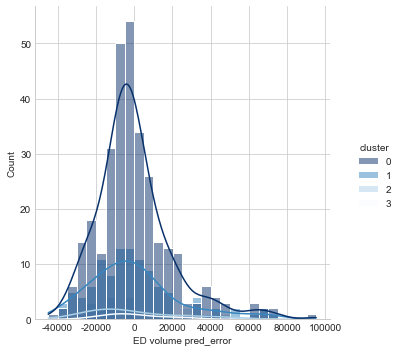

In [67]:

plt.style.use('seaborn-whitegrid')
sns.displot(data = all_cluster_error, x = 'pred_error', rug_kws={'density': True}, hue = 'cluster', palette='Blues_r', kde = True)
plt.xlabel('ED volume pred_error')
plt.ylabel('Count')
plt.savefig(os.path.dirname(os.path.dirname(__vsc_ipynb_file__)) + ".\\plots\\拟合残差.png", bbox_inches = 'tight', dpi = 600)
